# Examining LAMOST Kepler Gaia crossmatch.

The version of this code used in the paper is implemented in code/data.py.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import FK5
from astropy.coordinates import ICRS
import astropy.coordinates as coord
from astropy.table import Table

plotpar = {'axes.labelsize': 30,
                  'font.size': 22,
                  'legend.fontsize': 15,
                  'xtick.labelsize': 30,
                  'ytick.labelsize': 30,
                  'text.usetex': True}
plt.rcParams.update(plotpar)

Figure out how to update apogee to dr3.

In [44]:
tbl = Table.read("../data/apogee_dr16_tmass_edr3_xmatch.fits", format='fits')
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
apo3 = tbl[names].to_pandas()

tbl = Table.read("../data/apogeedr16_stars.fits", format='fits')
names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
apo2 = tbl[names].to_pandas()

# crossmatch on dr2 source id.
apo23 = pd.merge(apo2, apo3, how="left", left_on="GAIA_SOURCE_ID", right_on="dr2_source_id")
apo23 = apo23.drop_duplicates(subset="dr3_source_id")

apo23 = pd.merge(apo2, apo3, how="left", left_on="GAIA_SOURCE_ID", right_on="dr2_source_id")

# Remove stars with very large separations
apo23 = apo23.iloc[apo23.angular_distance.values < 1]

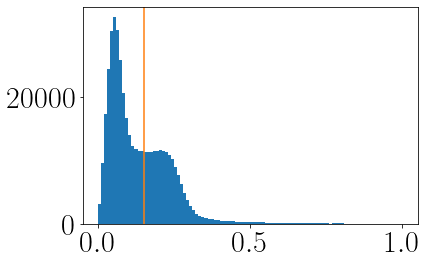

In [45]:
plt.hist(apo23.angular_distance.values, 100);
plt.axvline(.15, color="C1")

In [46]:
# for k in apo23.keys():
#     print(k)

# angular_distance'

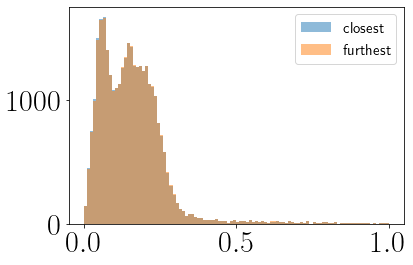

In [48]:
apo23_sorted = apo23.sort_values(by="angular_distance", ascending=True)

furthest = apo23_sorted.duplicated(subset="APOGEE_ID", keep="first")
closest = apo23_sorted.duplicated(subset="APOGEE_ID", keep="last")

plt.hist(apo23_sorted.angular_distance.values[closest], 100, alpha=.5, label="closest");
plt.hist(apo23_sorted.angular_distance.values[furthest], 100, alpha=.5, label="furthest");
plt.legend()

Create a file with Gaia eDR3 source id, and ra and dec in J2000.

Load Kepler-Gaia crossmatch

In [55]:
with fits.open("../../data/kepler_edr3_1arcsec.fits") as data:
    gaia3_og = pd.DataFrame(data[1].data, dtype="float64")
# for k in gaia3.keys():
#     print(k)

# If a target is duplicated, keep the one with the smallest angular separation.
gaia3_og["ind"] = np.arange(len(gaia3_og))
gaia3_sorted = gaia3_og.sort_values(by="kepler_gaia_ang_dist")
gaia3_sorted = gaia3_sorted.drop_duplicates(subset="kepid", keep="first")
gaia3 = gaia3_sorted.drop_duplicates(subset="source_id", keep="first")
gaia3 = gaia3.sort_values(by="ind")

print(len(gaia3_og)-len(gaia3), "duplicates dropped")
print(len(gaia3_og), len(gaia3), len(gaia3.drop_duplicates(subset="kepid")), len(gaia3.drop_duplicates(subset="source_id")))

3317 duplicates dropped
198451 195134 195134 195134


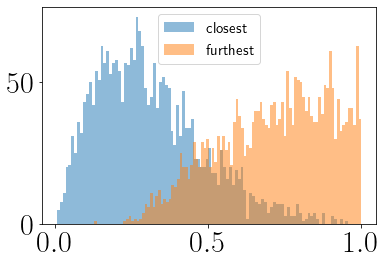

In [51]:
gaia3_sorted = gaia3_og.sort_values(by="kepler_gaia_ang_dist", ascending=True)

furthest = gaia3_sorted.duplicated(subset="kepid", keep="first")
closest = gaia3_sorted.duplicated(subset="kepid", keep="last")

plt.hist(gaia3_sorted.kepler_gaia_ang_dist[closest], 100, alpha=.5, label="closest");
plt.hist(gaia3_sorted.kepler_gaia_ang_dist[furthest], 100, alpha=.5, label="furthest");
plt.legend()

195134 186601


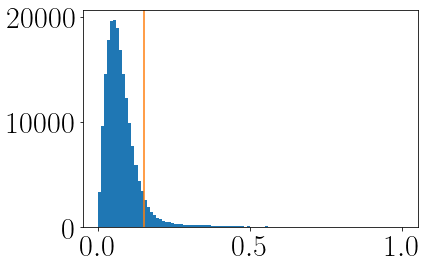

In [56]:
plt.hist(gaia3.kepler_gaia_ang_dist, 100);
plt.axvline(.15, color="C1")
print(len(gaia3), sum(gaia3.kepler_gaia_ang_dist.values < .2))
# plt.ylim(0, 1000)

In [20]:
m_ruwe = gaia3.ruwe.values < 1.4
m_multi = gaia3.ipd_frac_multi_peak.values <= 2.
m_harmonic = gaia3.ipd_gof_harmonic_amplitude.values < .1
m_separation = gaia3.kepler_gaia_ang_dist.values < .2
m_flag = m_ruwe & m_multi & m_harmonic & m_separation
print(sum(m_flag), len(gaia3))

163630 198451


In [21]:
# fk5c = SkyCoord(ra=gaia3.ra.values*u.degree, dec=gaia3.dec.values*u.degree, frame=FK5, equinox="J2015.5")
# fk5_2000 = FK5(equinox='J2000')  # String initializes an astropy.time.Time object
# j2000 = fk5c.transform_to(fk5_2000)
# print(j2000.ra.degree[:10], print(gaia3.ra.values[10:]))

In [22]:
# plt.plot(gaia3.ra, gaia3.dec, ".", ms=1, alpha=.5)
# plt.plot(j2000.ra.degree,j2000.dec.degree, ".", ms=1, alpha=.5)

In [23]:
# ra_diff = gaia3.ra.values - j2000.ra.degree
# plt.hist(ra_diff, 100);

In [24]:
# source_id = [str(int(i)) for i in gaia3.source_id.values]
# kg3 = pd.DataFrame(dict({"dr3_source_id": source_id,
#                          "ra": gaia3.ra.values,
#                          "dec": gaia3.dec.values}))
# #                          "raJ2000": j2000.ra.degree,
# #                          "decJ2000": j2000.dec.degree}))
# kg3.to_csv("../data/gaia_for_lamost_crossmatch.csv", index=False)

In [25]:
# kg3 = pd.DataFrame(dict({"dr3_source_id": source_id,
#                          "ra": j2000.ra.degree,
#                          "dec": j2000.dec.degree,
#                          "sep": np.ones(len(source_id))}))
# kg3 = kg3.iloc[:10]
# kg3.to_csv("../data/gaia_for_lamost_crossmatch_short.csv", index=False)

In [62]:
lamost = pd.read_csv("../data/gaia-kepler-lamost_snr.csv")

In [63]:
for k in lamost.keys():
    print(k)
np.shape(lamost)
# plt.hist(lamost.angDist, 100);

inputobjs_input_id
inputobjs_input_ra
inputobjs_input_dec
inputobjs_dist
catalogue_obsid
catalogue_obsdate
catalogue_planid
catalogue_spid
catalogue_fiberid
catalogue_snru
catalogue_snrg
catalogue_snrr
catalogue_snri
catalogue_snrz
catalogue_class
catalogue_subclass
catalogue_z
catalogue_z_err
catalogue_ra
catalogue_dec
stellar_teff
stellar_teff_err
stellar_logg
stellar_logg_err
stellar_feh
stellar_feh_err
stellar_rv
stellar_rv_err


(123039, 28)

In [109]:
# np.shape(lamost)

In [159]:
# with fits.open("../data/kepler_dr2_1arcsec.fits") as data:
#     gaia = pd.DataFrame(data[1].data, dtype="float64")

Merge Gaia and LAMOST catalogs using RA and dec. Merge Gaia and APOGEE using source_id.

In [91]:
def load_and_merge_data(edr3=True, max_angular_separation=.5):
    
    # Load Gaia-Kepler crossmatch
    print("Loading Gaia-Kepler crossmatch...")
    with fits.open("../data/kepler_dr2_1arcsec.fits") as data:
        gaia = pd.DataFrame(data[1].data, dtype="float64")
    m = gaia.parallax.values > 0
    gaia = gaia.iloc[m]
    
    # Round RVs down to 6dp.
    gaia["ra_6dp"] = np.round(gaia.ra.values, 6)
    gaia["dec_6dp"] = np.round(gaia.dec.values, 6)

    # Add LAMOST
    # File created using the LAMOST DR5 website: http://dr5.lamost.org/search
    print("Loading Lamost")
    lamost = pd.read_csv("../data/gaia-kepler-lamost_snr.csv")

    # Remove one star with a giant LAMOST RV errorbar
    m = abs(lamost.stellar_rv_err.values) < 100
    lamost = lamost.iloc[m]

    # Merge Gaia and LAMOST on (rounded) RA and dec
    lamost["ra_6dp"] = lamost.inputobjs_input_ra.values
    lamost["dec_6dp"] = lamost.inputobjs_input_dec.values
    
#     lamost_stripped = pd.DataFrame(dict({"ra_6dp": lamost.inputobjs_input_ra.values,
#                                          "dec_6dp": lamost.inputobjs_input_dec.values,
#                                          "stellar_rv": lamost.stellar_rv.values,
#                                          "stellar_rv_err": lamost.stellar_rv_err.values}))
    lamost_stripped = lamost
    
    # If you want edr3, just match on kepid then match again with edr3.
    if edr3:
        print("Merging LAMOST and Gaia DR3")
        gaia_stripped = pd.DataFrame(dict({"ra_6dp": gaia["ra_6dp"],
                                           "dec_6dp": gaia["dec_6dp"],
                                           "kepid": gaia["kepid"],
                                           "r_est": gaia["r_est"],
                                           "r_lo": gaia["r_lo"],
                                           "r_hi": gaia["r_hi"]}))
        lamost_gaia = pd.merge(gaia_stripped, lamost_stripped, on=["ra_6dp", "dec_6dp"],
                               how="left")
        
        with fits.open("../../data/kepler_edr3_1arcsec.fits") as data:
            gaia3 = pd.DataFrame(data[1].data, dtype="float64")
        m = gaia3.parallax.values > 0
        gaia3 = gaia3.iloc[m]
        og = len(gaia3)*1
        
        # If a target is duplicated, keep the one with the smallest angular separation.
        gaia3["ind"] = np.arange(len(gaia3))
        gaia3_sorted = gaia3.sort_values(by="kepler_gaia_ang_dist")
        gaia3_sorted = gaia3_sorted.drop_duplicates(subset="kepid", keep="first")
        gaia3_sorted = gaia3_sorted.drop_duplicates(subset="source_id", keep="first")
        gaia3 = gaia3_sorted.sort_values(by="ind")
        print(og - len(gaia3), "duplicate sources removed")
            
        # Cut out potential binaries:
        m_ruwe = gaia3.ruwe.values < 1.4
        m_multi = gaia3.ipd_frac_multi_peak.values <= 2.
        m_harmonic = gaia3.ipd_gof_harmonic_amplitude.values < .1
        
        # Make sure stars are nearby on the sky
        m_separation = gaia3.kepler_gaia_ang_dist.values < max_angular_separation
        print(len(gaia3) - sum(m_separation), "stars removed from kepler-gaia distance cut")
        
        m_flag = m_ruwe & m_multi & m_harmonic & m_separation
        gaia3 = gaia3.iloc[m_flag]
        
        # Merge DR2 and 3
        gaia23 = pd.merge(gaia_stripped, gaia3, on="kepid", how="right")
        
        # Merge DR3 and lamost
        lamost_gaia = pd.merge(gaia23, lamost, on=["ra_6dp", "dec_6dp"],
                               how="left", suffixes=["_gaia_edr3", "_lamost"])
        lamost_gaia["radial_velocity"] = lamost_gaia["dr2_radial_velocity"]
        lamost_gaia["radial_velocity_error"] = lamost_gaia["dr2_radial_velocity_error"]
    
    else:
        print("Merging LAMOST and Gaia DR2")
        lamost_gaia = pd.merge(gaia, lamost_stripped, on=["ra_6dp", "dec_6dp"],
                               how="left", suffixes=["", "_lamost"])
        
    print(len(lamost_gaia.duplicated(subset="source_id") == True), "duplicated sources after LAMOST merge")
    
#     lamost_gaia = lamost_gaia.drop_duplicates(subset="source_id")

    # Load apogee
    print("Loading APOGEE")
    if edr3:

        tbl = Table.read("../data/apogee_dr16_tmass_edr3_xmatch.fits", format='fits')
        names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
        apo3_og = tbl[names].to_pandas()
        
        # Remove sources with large angular separations
        apo3 = apo3_og.iloc[apo3_og.angular_distance.values < max_angular_separation]
        print(len(apo3_og) - len(apo3), "of", len(apo3_og), "stars removed from apo-gaia distance cut")

        tbl = Table.read("../data/apogeedr16_stars.fits", format='fits')
        names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
        apo2 = tbl[names].to_pandas()

        # crossmatch on dr2 source id.
        apo23 = pd.merge(apo2, apo3, how="left", left_on="GAIA_SOURCE_ID", right_on="dr2_source_id")
#         apo23 = apo23.drop_duplicates(subset="dr3_source_id")

        # Only keep what you need from apogee
        apo_stripped = pd.DataFrame(dict({"dr3_source_id": apo23.dr3_source_id.values,
                                          "OBSVHELIO_AVG": apo23.OBSVHELIO_AVG.values,
                                          "OBSVERR": apo23.OBSVERR.values}))
        apo_stripped = apo23

        apodf = pd.merge(apo_stripped, lamost_gaia, how="right", left_on="dr3_source_id", right_on="source_id", 
                         suffixes=["_apogee", ""])
        print(np.shape(lamost_gaia), np.shape(apodf))
        
    else:
        tbl = Table.read("../data/apogeedr16_stars.fits", format='fits')
        names = [name for name in tbl.colnames if len(tbl[name].shape) <= 1]
        apo = tbl[names].to_pandas()

        print("Merging Gaia and Apogee")
        apodf = pd.merge(apo, lamost_gaia, how="right", left_on="GAIA_SOURCE_ID",
                         right_on="source_id", suffixes=["_apogee", ""])
        
#     apodf = apodf.drop_duplicates(subset="source_id")
         
    # Make sure J H K match
    thresh = .3
    m_jhk = (abs(apodf.jmag.values - apodf.J.values) < thresh) & (abs(apodf.kmag.values - apodf.K.values) < thresh) \
        & (abs(apodf.hmag.values - apodf.H.values) < thresh)
    apodf = apodf.iloc[m_jhk]
    
    return apodf

In [92]:
def fit_line(x, y, yerr):
    AT = np.vstack((np.ones(len(x)), x))
    C = np.eye(len(x))*yerr
    CA = np.linalg.solve(C, AT.T)
    Cy = np.linalg.solve(C, y)
    ATCA = np.dot(AT, CA)
    ATCy = np.dot(AT, Cy)
    w = np.linalg.solve(ATCA, ATCy)

    cov = np.linalg.inv(ATCA)
    sig = np.sqrt(np.diag(cov))
    return w, sig

def combine_rv_measurements(df):
    """
    Combine RVs from LAMOST, Gaia, and APOGEE into one column,

    LAMOST RVs are overwritten by Gaia RVs, which are overwritten by APOGEE
    RVS.
    LAMOST RVs are called 'stellar_rv, stellar_rv_err',
    Gaia are called 'radial_velocity, radial_velocity_error',
    APOGEE are called 'OBSVHELIO_AVG, OBSVERR'.
    """

    rv, rv_err = [np.ones(len(df))*np.nan for i in range(2)]
    
    ml = np.isfinite(df.stellar_rv.values)
    mg = np.isfinite(df.radial_velocity.values) & (df.radial_velocity.values != 0)
    ma = np.isfinite(df.OBSVHELIO_AVG.values)
    mlmgma = ml & mg & ma
    mlmg = ml & mg
    mamg = ma & mg

    # Correct LAMOST RVs
    x, y = df.radial_velocity.values[mlmg], df.stellar_rv.values[mlmg]-df.radial_velocity.values[mlmg]
    yerr = df.stellar_rv_err.values[mlmg]
    w, sig = fit_line(x, y, yerr)
    lamost_corrected = df.stellar_rv.values - (w[0] + w[1]*df.stellar_rv.values)
    df["lamost_corrected_rv"] = lamost_corrected

    rv[ml] = lamost_corrected[ml]
    rv_err[ml] = df.stellar_rv_err.values[ml]
    print(sum(ml), "stars with LAMOST RVs")

    # Overwrite LAMOST RVs with Gaia RVs
    rv[mg] = df.radial_velocity.values[mg]
    rv_err[mg] = df.radial_velocity_error.values[mg]
    print(sum(mg), "stars with Gaia RVs")

    # Correct APOGEE RVs
    # remove outliers
    tot_err = np.sqrt(df.radial_velocity_error.values[mamg]**2 + df.OBSVERR.values[mamg]**2)
    ro = abs(df.OBSVHELIO_AVG.values[mamg] - df.radial_velocity.values[mamg]) < 3 * tot_err
    
    x, y = df.radial_velocity.values[mamg], df.OBSVHELIO_AVG.values[mamg]-df.radial_velocity.values[mamg]
    yerr = df.OBSVERR.values[mamg]
    w, sig = fit_line(x, y, yerr)
    apogee_corrected = df.OBSVHELIO_AVG.values - (w[0] + w[1]*df.OBSVHELIO_AVG.values)
    df["apogee_corrected_rv"] = apogee_corrected
    
    # Overwrite Gaia RVs with APOGEE RVs
    rv[ma] = apogee_corrected[ma]
    rv_err[ma] = df.OBSVERR.values[ma]
    print(sum(ma), "stars with APOGEE RVs")

    print(sum(np.isfinite(rv)), "stars with RVs")
    print(sum(mlmg), "with LAMOST and Gaia")
    print(sum(mlmgma), "with all three")

    df["rv"] = rv
    df["rv_err"] = rv_err
    return df

In [93]:
df0 = load_and_merge_data(edr3=True)
df = combine_rv_measurements(df0)

Loading Gaia-Kepler crossmatch...
Loading Lamost
Merging LAMOST and Gaia DR3
3214 duplicate sources removed
1508 stars removed from kepler-gaia distance cut
188437 duplicated sources after LAMOST merge
Loading APOGEE
19858 of 423517 stars removed from apo-gaia distance cut
(188437, 169) (188617, 476)
13467 stars with LAMOST RVs
20948 stars with Gaia RVs
25190 stars with APOGEE RVs
25190 stars with RVs
11914 with LAMOST and Gaia
11914 with all three


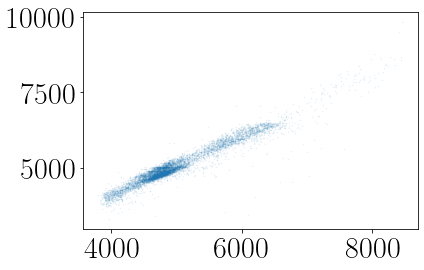

In [53]:
plt.plot(df.stellar_teff, df.teff, ".", ms=1, alpha=.1)

Text(0.5, 0, 'H')

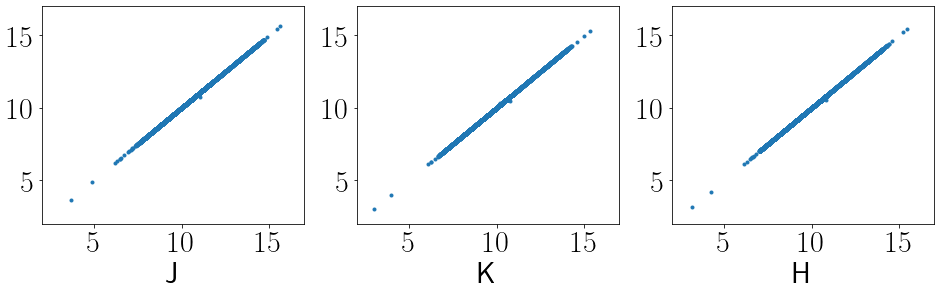

In [54]:
# m = (df.jmag.values < 100) & (df.J.values < 50) & (df.kmag.values < 100) & (df.hmag.values < 100)

# ax0.plot(df.jmag.values[m], df.J.values[m], ".")
# ax1.plot(df.kmag.values[m], df.K.values[m], ".")
# ax2.plot(df.hmag.values[m], df.H.values[m], ".")

fig = plt.figure(figsize=(16, 4))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

thresh = .3
same = (abs(df.jmag.values - df.J.values) < thresh) & (abs(df.kmag.values - df.K.values) < thresh) & (abs(df.hmag.values - df.H.values) < thresh)

ax0.plot(df.jmag.values[same], df.J.values[same], ".")
ax0.plot(df.jmag.values[~same], df.J.values[~same], ".")
ax0.set_xlim(2, 17)
ax0.set_ylim(2, 17)
ax0.set_xlabel("J")

ax1.plot(df.kmag.values[same], df.K.values[same], ".")
ax1.plot(df.kmag.values[~same], df.K.values[~same], ".")
ax1.set_xlim(2, 17)
ax1.set_ylim(2, 17)
ax1.set_xlabel("K")

ax2.plot(df.hmag.values[same], df.H.values[same], ".")
ax2.plot(df.hmag.values[~same], df.H.values[~same], ".")
ax2.set_xlim(2, 17)
ax2.set_ylim(2, 17)
ax2.set_xlabel("H")

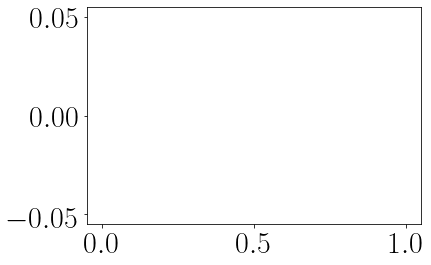

In [69]:
dupe = df.duplicated(subset="kepid")
dupes = df.kepler_gaia_ang_dist[dupe]
plt.hist(dupes, 100);

In [33]:
for k in df.keys():
    print(k)

APOGEE_ID
TELESCOPE
FIELD
J
J_ERR
H
H_ERR
K
K_ERR
RA
DEC
GLON
GLAT
APOGEE_TARGET1
APOGEE_TARGET2
APOGEE_TARGET3
APOGEE2_TARGET1
APOGEE2_TARGET2
APOGEE2_TARGET3
TARGFLAGS
SURVEY
PROGRAMNAME
NVISITS
COMBTYPE
COMMISS
SNR
STARFLAG
STARFLAGS
ANDFLAG
ANDFLAGS
VHELIO_AVG
VSCATTER
VERR
VERR_MED
OBSVHELIO_AVG
OBSVSCATTER
OBSVERR
OBSVERR_MED
SYNTHVHELIO_AVG
SYNTHVSCATTER
SYNTHVERR
SYNTHVERR_MED
RV_TEFF
RV_LOGG
RV_FEH
RV_ALPHA
RV_CARB
RV_CCFWHM
RV_AUTOFWHM
SYNTHSCATTER
MEANFIB
SIGFIB
SNREV
APSTAR_VERSION
ASPCAP_VERSION
RESULTS_VERSION
EXTRATARG
MIN_H
MAX_H
MIN_JK
MAX_JK
TEFF
TEFF_ERR
LOGG
LOGG_ERR
VMICRO
VMACRO
VSINI
M_H
M_H_ERR
ALPHA_M
ALPHA_M_ERR
ASPCAP_CHI2
ASPCAP_CLASS
ASPCAPFLAG
ASPCAPFLAGS
C_FE
CI_FE
N_FE
O_FE
NA_FE
MG_FE
AL_FE
SI_FE
P_FE
S_FE
K_FE
CA_FE
TI_FE
TIII_FE
V_FE
CR_FE
MN_FE
FE_H
CO_FE
NI_FE
CU_FE
GE_FE
RB_FE
CE_FE
ND_FE
YB_FE
C_FE_ERR
CI_FE_ERR
N_FE_ERR
O_FE_ERR
NA_FE_ERR
MG_FE_ERR
AL_FE_ERR
SI_FE_ERR
P_FE_ERR
S_FE_ERR
K_FE_ERR
CA_FE_ERR
TI_FE_ERR
TIII_FE_ERR
V_FE_ERR
CR_FE_ERR
M

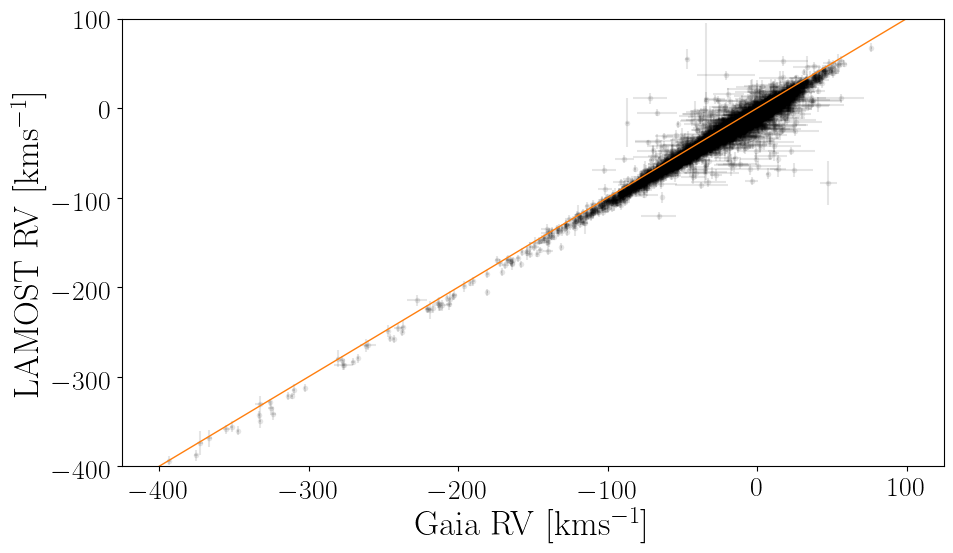

In [28]:
ml = np.isfinite(df.stellar_rv.values)
mg = np.isfinite(df.dr2_radial_velocity.values) & (df.dr2_radial_velocity.values != 0)
mlmg = ml & mg

plt.figure(figsize=(10, 6), dpi=100)
plt.errorbar(df.dr2_radial_velocity.values[mlmg], df.stellar_rv[mlmg],
             xerr=df.dr2_radial_velocity_error.values[mlmg],
             yerr=df.stellar_rv_err.values[mlmg],
             fmt="k.", alpha=.1, ms=8, mec="none", zorder=0, rasterized=True)
xs = np.linspace(-400, 100, 100)
plt.plot(xs, xs, "C1", lw=1, zorder=1)
plt.ylim(-400, 100)
plt.xlabel("$\mathrm{Gaia~RV~[km s^{-1}]}$")
plt.ylabel("$\mathrm{LAMOST~RV~[km s^{-1}]}$")
plt.tight_layout()

Text(0, 0.5, 'dec')

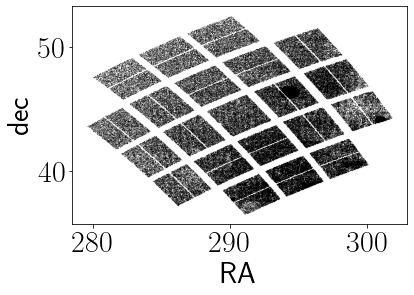

In [146]:
plt.plot(df.ra, df.dec, "k.", ms=.1, rasterized=True)
plt.xlabel("RA")
plt.ylabel("dec")

In [147]:
ml = np.isfinite(df.stellar_rv.values)
mg = np.isfinite(df.radial_velocity.values) & (df.radial_velocity.values != 0)
ma = np.isfinite(df.OBSVHELIO_AVG.values)
mlmgma = ml & mg & ma
mlmg = ml & mg
mamg = ma & mg

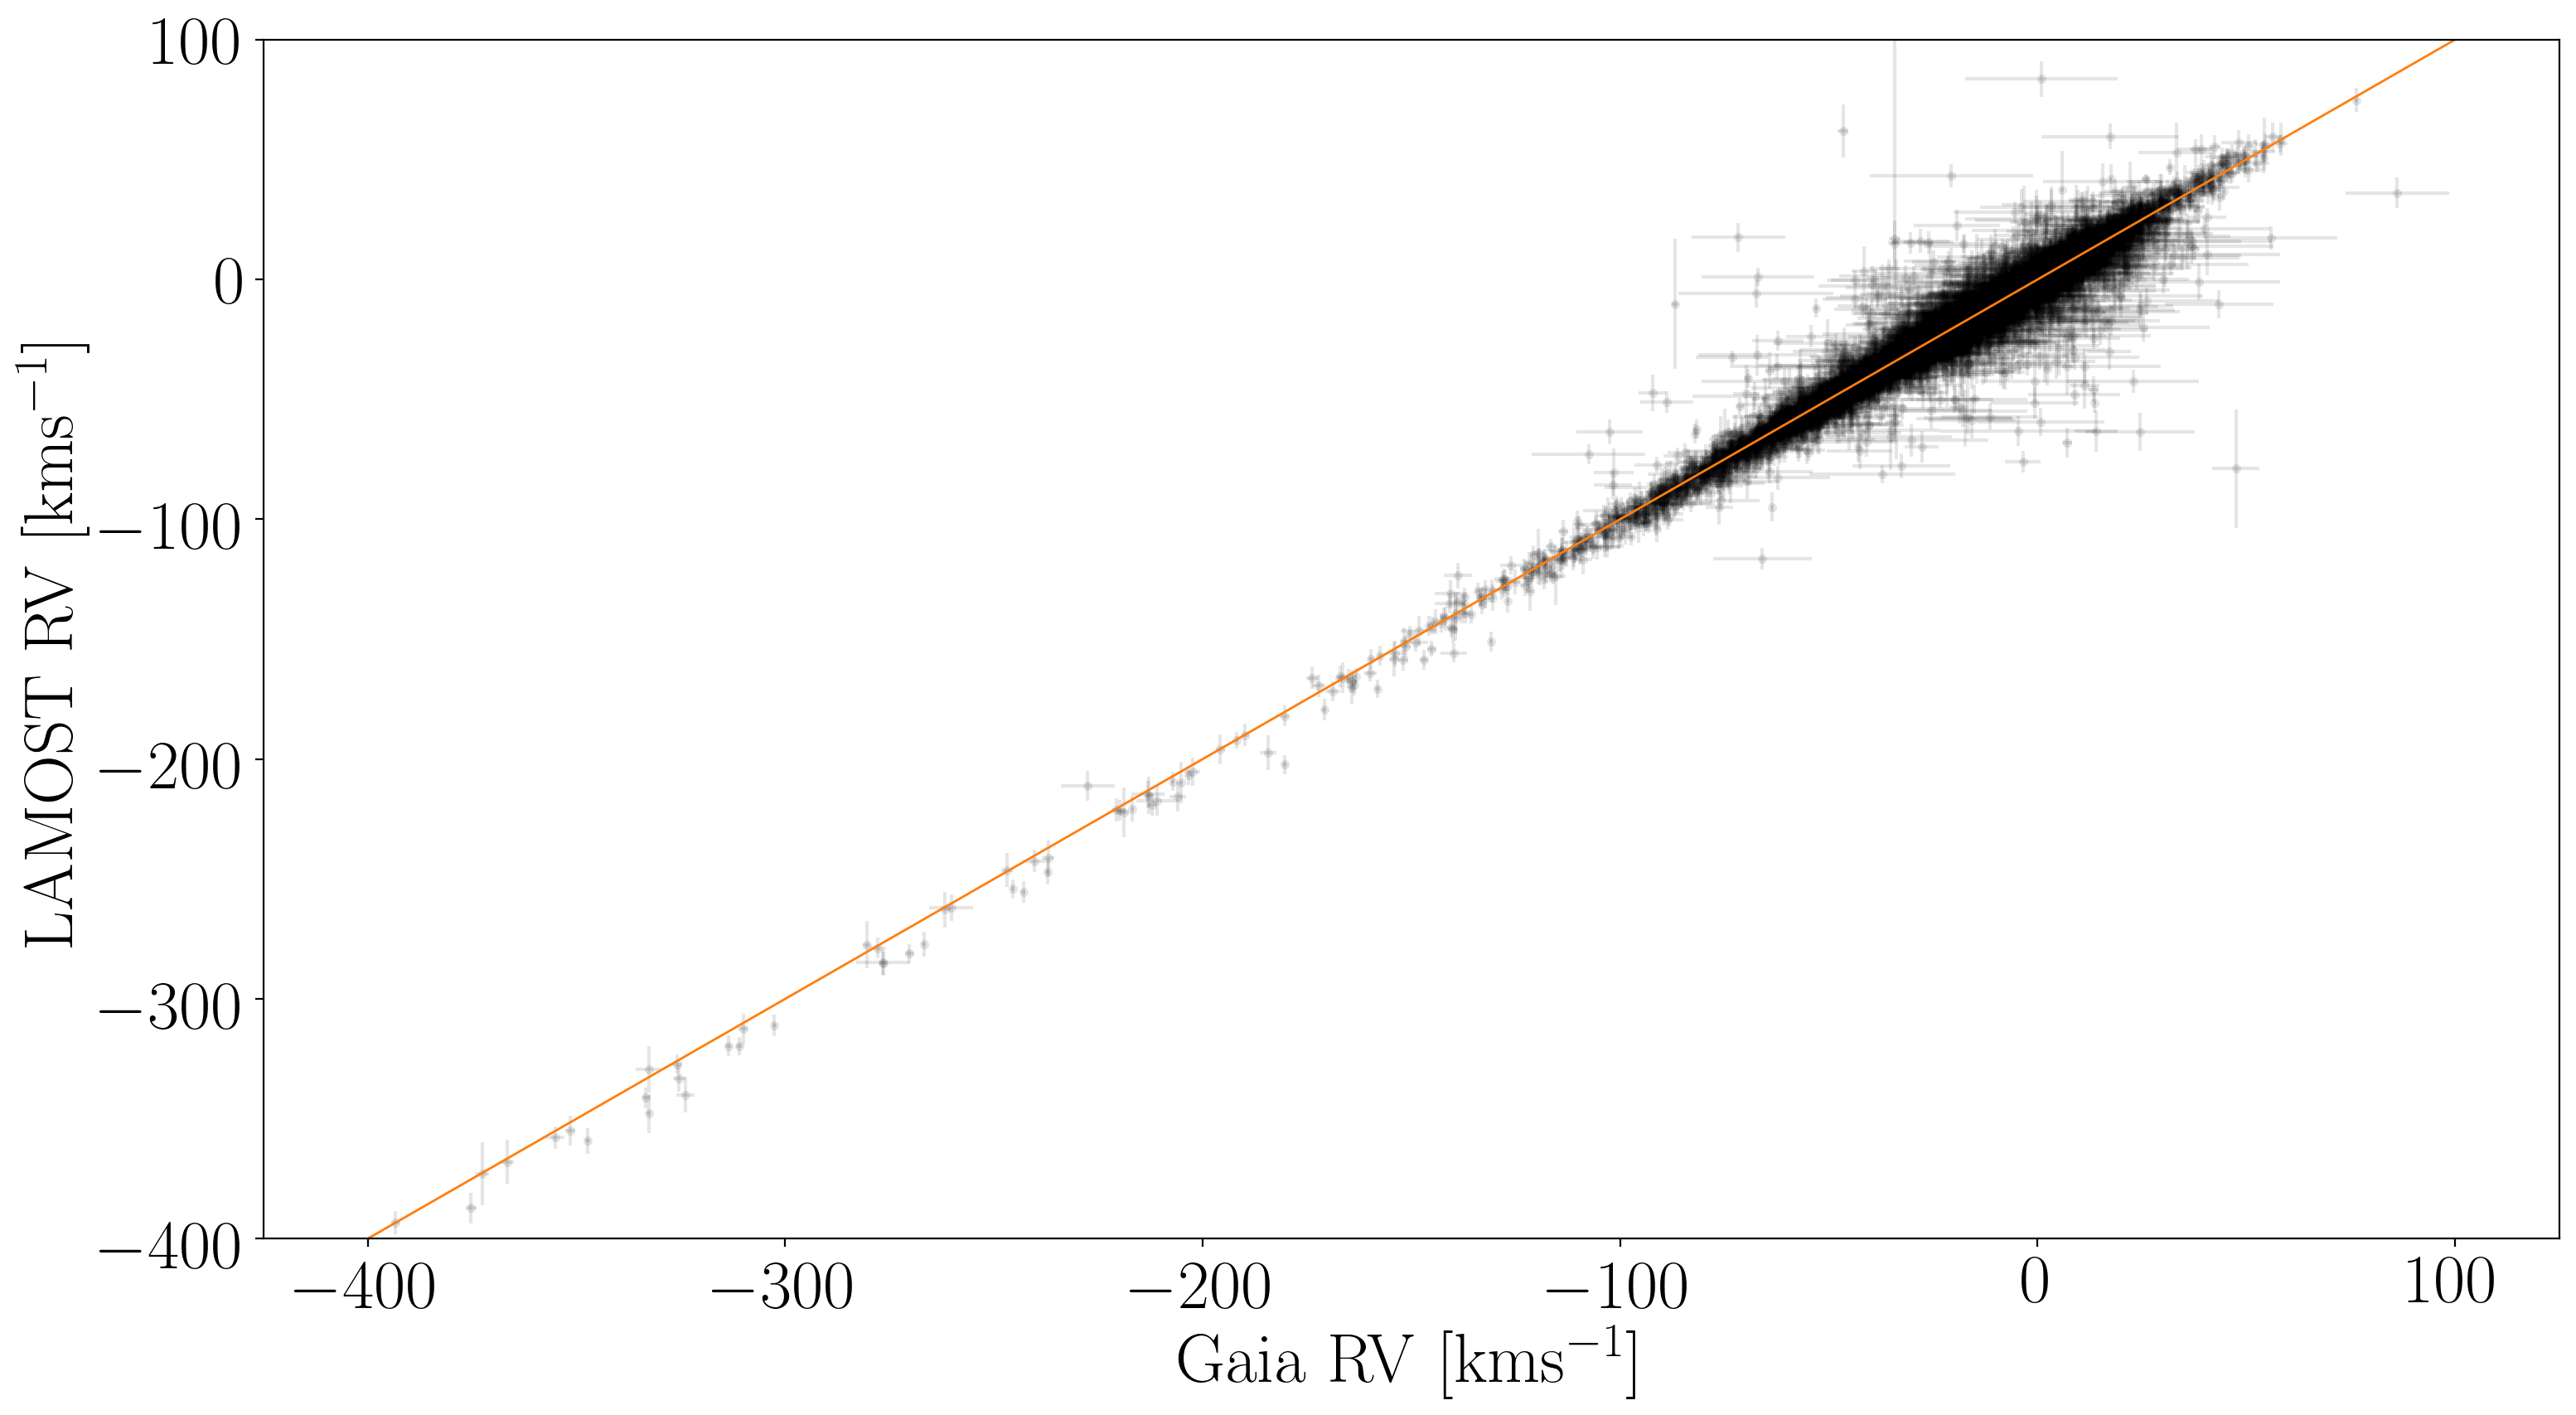

In [148]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(df.radial_velocity.values[mlmg], df.lamost_corrected_rv[mlmg],
             xerr=df.radial_velocity_error.values[mlmg],
             yerr=df.stellar_rv_err.values[mlmg],
             fmt="k.", alpha=.1, ms=8, mec="none", zorder=0, rasterized=True)
xs = np.linspace(-400, 100, 100)
plt.plot(xs, xs, "C1", lw=1, zorder=1)
plt.ylim(-400, 100)
plt.xlabel("$\mathrm{Gaia~RV~[km s^{-1}]}$")
plt.ylabel("$\mathrm{LAMOST~RV~[km s^{-1}]}$")
plt.tight_layout()

Plot a histogram of the residuals.

1.0611132745428333 0.009016836090323976
1.0877555699713262 1.2335245207434904


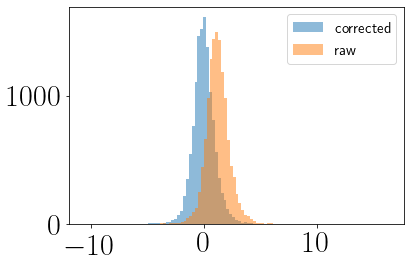

In [149]:
tot_err = np.sqrt(df.radial_velocity_error.values[mlmg]**2 + df.stellar_rv_err.values[mlmg]**2)
resids = df.radial_velocity.values[mlmg] - df.lamost_corrected_rv.values[mlmg]
plt.hist(resids/tot_err, 100, alpha=.5, label="corrected");
print(np.std(resids/tot_err), np.mean(resids/tot_err))

resids2 = df.radial_velocity.values[mlmg] - df.stellar_rv.values[mlmg]
plt.hist(resids2/tot_err, 100, alpha=.5, label="raw");
print(np.std(resids2/tot_err), np.mean(resids2/tot_err))

plt.legend()

Now look at the APOGEE RVs.

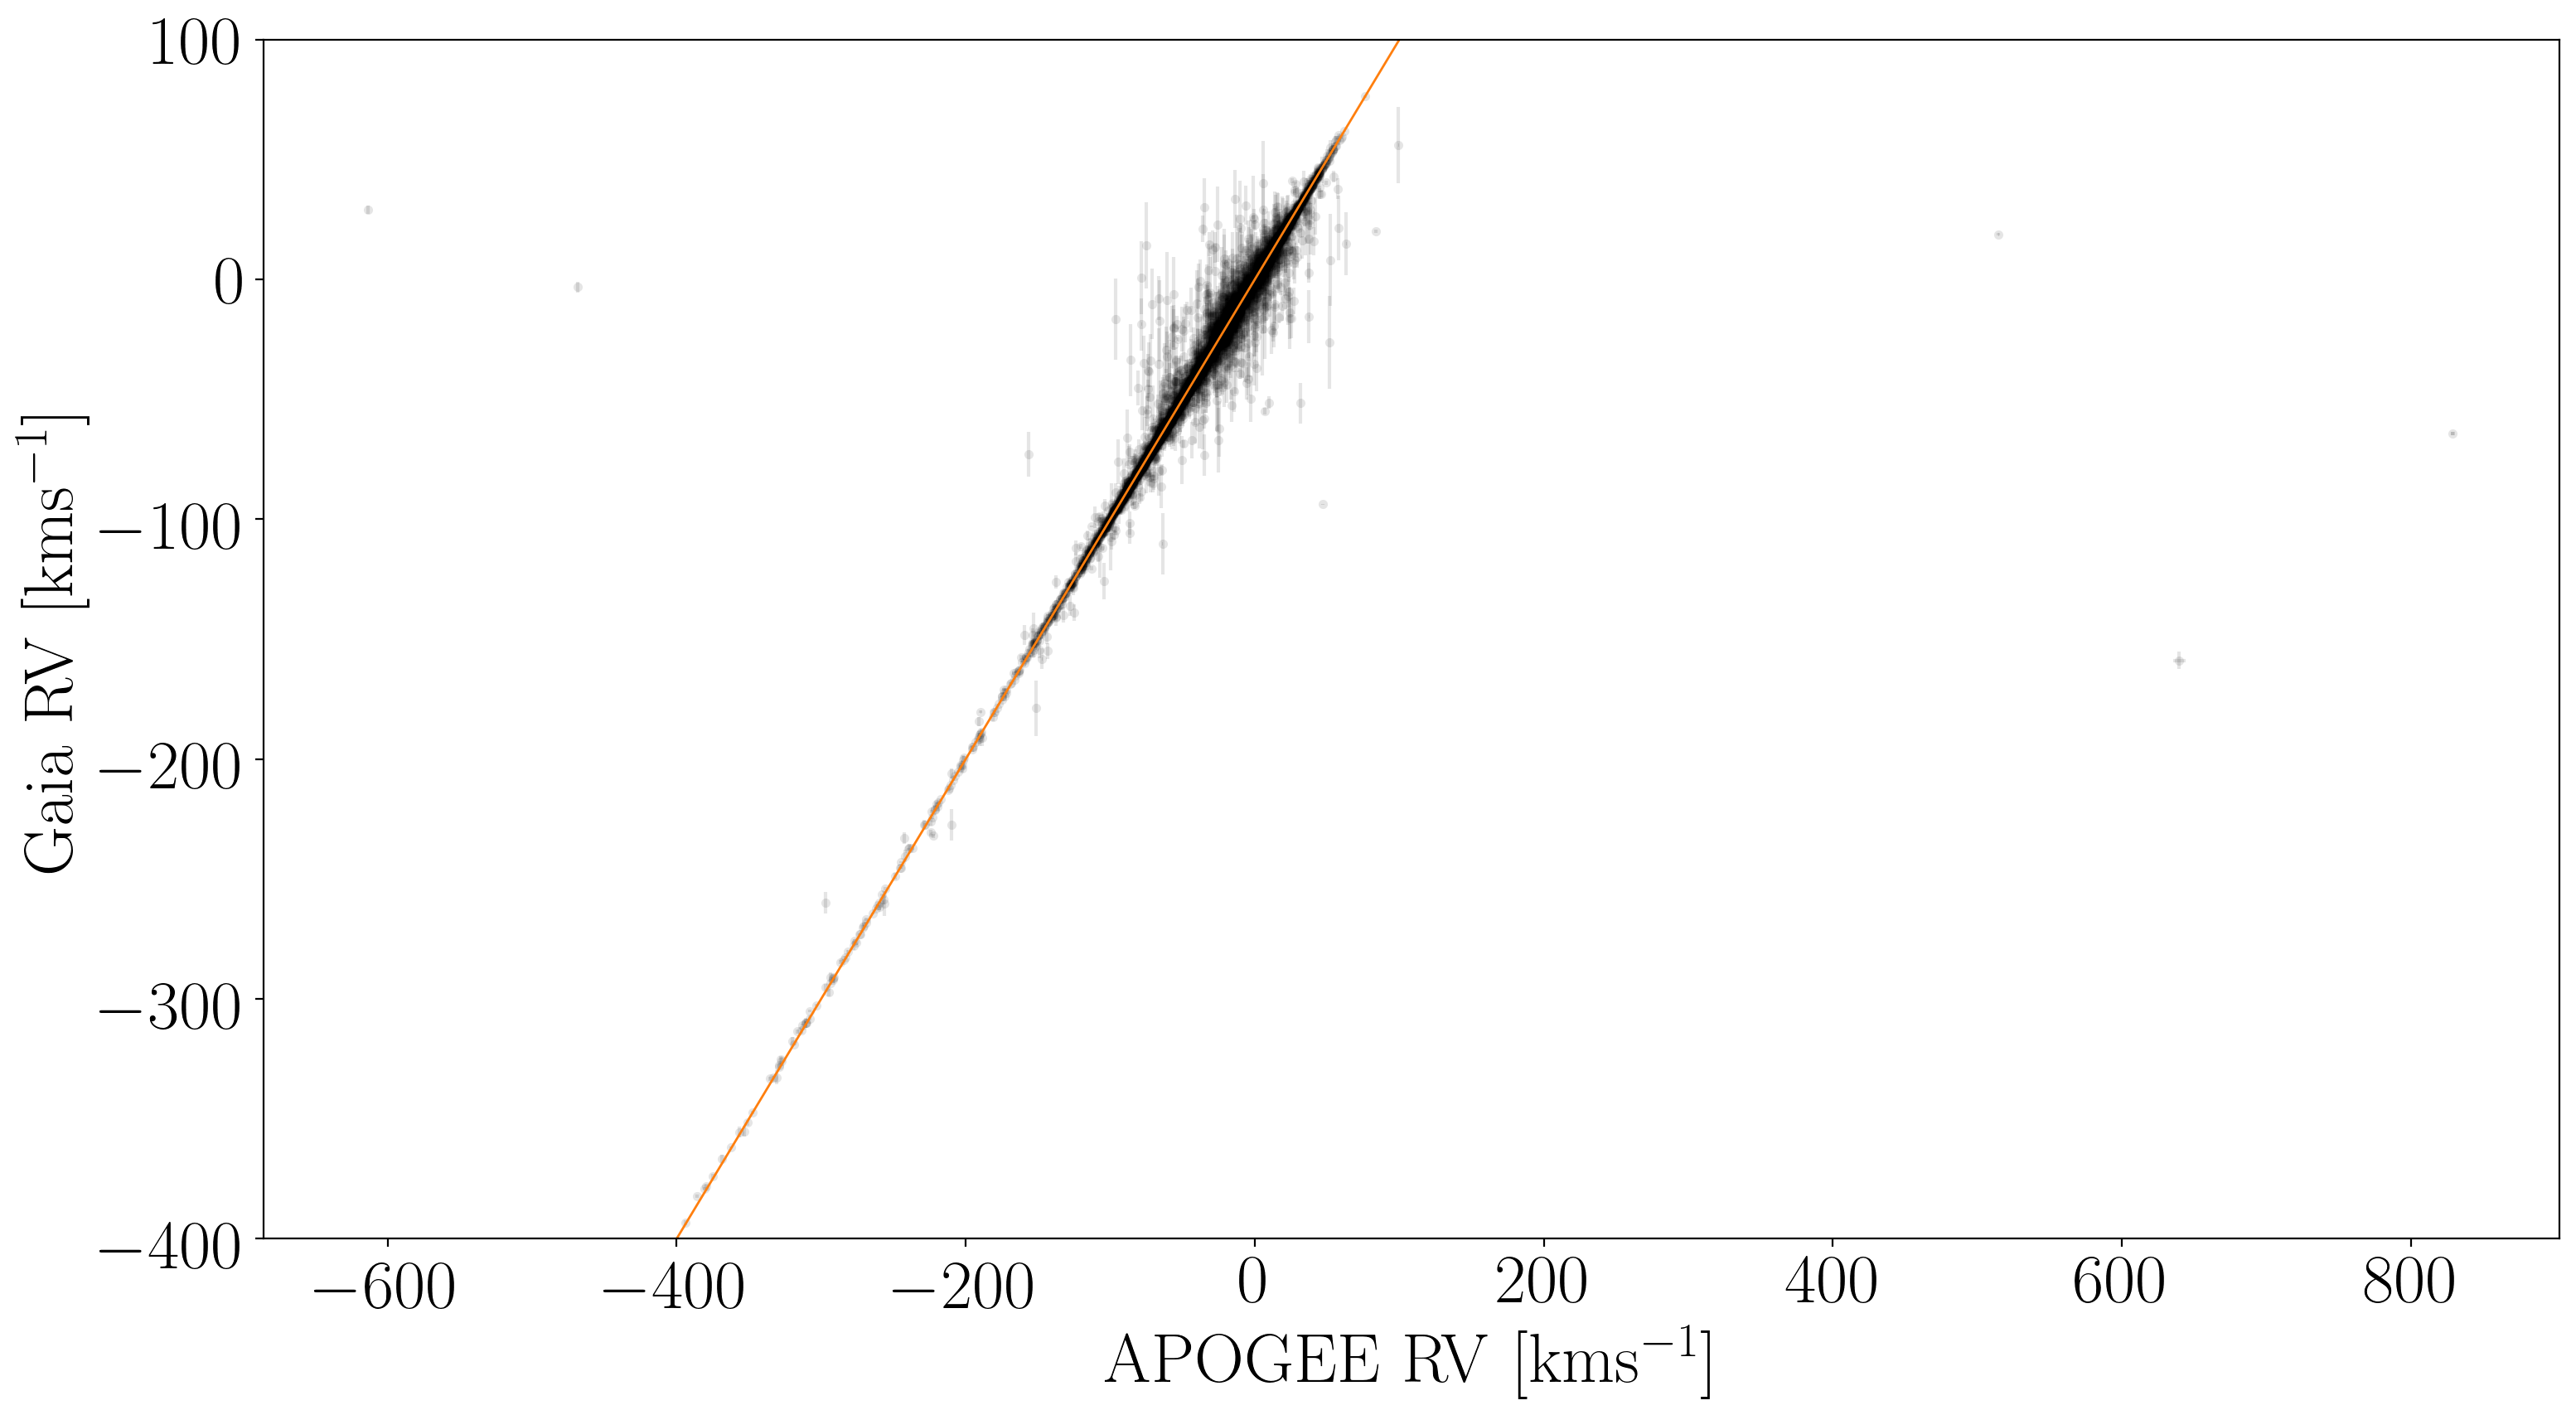

In [150]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(df.apogee_corrected_rv[mamg], df.radial_velocity.values[mamg],
             yerr=df.radial_velocity_error.values[mamg],
             xerr=df.OBSVERR.values[mamg],
             fmt="k.", alpha=.1, ms=8, mec="none", zorder=0, rasterized=True)
xs = np.linspace(-400, 100, 100)
plt.plot(xs, xs, "C1", lw=1, zorder=1)
plt.ylim(-400, 100)
plt.ylabel("$\mathrm{Gaia~RV~[km s^{-1}]}$")
plt.xlabel("$\mathrm{APOGEE~RV~[km s^{-1}]}$")
plt.tight_layout()

1.6576536011110345 0.15306583533162743
1.6890524487718517 -0.049050454377337016


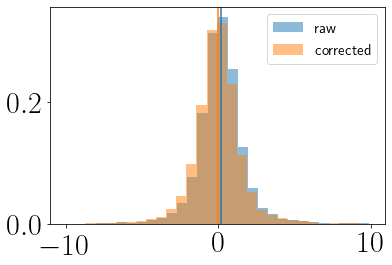

In [151]:
tot_err = np.sqrt(df.radial_velocity_error.values[mamg]**2 + df.OBSVERR.values[mamg]**2)
ro = abs(df.OBSVHELIO_AVG.values[mamg] - df.radial_velocity.values[mamg]) < 10 * tot_err

resids = df.radial_velocity.values[mamg][ro] - df.OBSVHELIO_AVG.values[mamg][ro]
resids2 = df.radial_velocity.values[mamg][ro] - df.apogee_corrected_rv.values[mamg][ro]
plt.hist(resids/tot_err[ro], 30, density=True, alpha=.5, label="raw");
print(np.std(resids/tot_err[ro]), np.mean(resids/tot_err[ro]))
plt.axvline(np.mean(resids/tot_err[ro]))

plt.hist(resids2/tot_err[ro], 30, density=True, alpha=.5, label="corrected");
print(np.std(resids2/tot_err[ro]), np.mean(resids2/tot_err[ro]))
plt.axvline(np.mean(resids2/tot_err[ro]), color="C1")

plt.legend()

# Here's one I made earlier

Load the file output by data.py

In [2]:
df = pd.read_csv("../kepler_kinematics/gaia_kepler_lamost.csv")
print(np.shape(df))
df = df.drop_duplicates(subset="source_id")
print(np.shape(df))

(185223, 193)
(184557, 193)


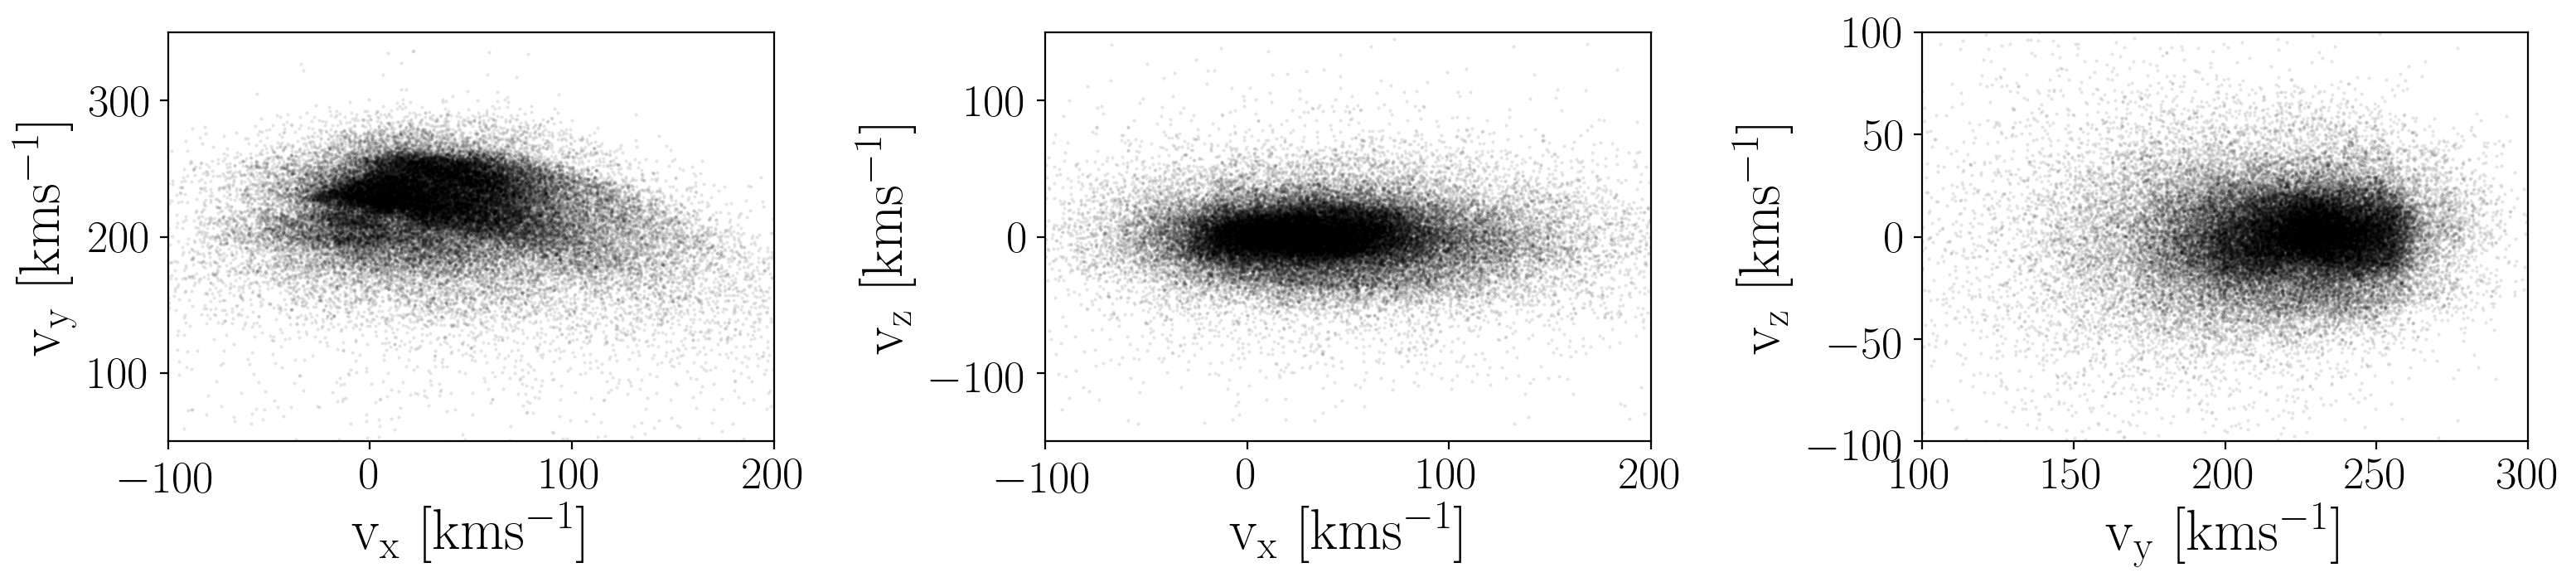

In [3]:
plotpar = {'axes.labelsize': 25,
           'xtick.labelsize': 20,
           'ytick.labelsize': 20,
           'text.usetex': True}
plt.rcParams.update(plotpar)

fig = plt.figure(figsize=(16, 4), dpi=200)
ax0 = fig.add_subplot(131)
ax0.plot(df.vx, df.vy, "k.", ms=1, alpha=.1, rasterized=True)
ax0.set_xlim(-100, 200)
ax0.set_ylim(50, 350)
ax0.set_xlabel("$\mathrm{v_x~[km s^{-1}]}$")
ax0.set_ylabel("$\mathrm{v_y~[km s^{-1}]}$")

ax1 = fig.add_subplot(132)
ax1.plot(df.vx, df.vz, "k.", ms=1, alpha=.1, rasterized=True)
ax1.set_xlim(-100, 200)
ax1.set_ylim(-150, 150)
ax1.set_xlabel("$\mathrm{v_x~[km s^{-1}]}$")
ax1.set_ylabel("$\mathrm{v_z~[km s^{-1}]}$")

ax2 = fig.add_subplot(133)
ax2.plot(df.vy, df.vz, "k.", ms=1, alpha=.1, rasterized=True)
ax2.set_ylim(-100, 100)
ax2.set_xlim(100, 300)
ax2.set_xlabel("$\mathrm{v_y~[km s^{-1}]}$")
ax2.set_ylabel("$\mathrm{v_z~[km s^{-1}]}$")

plt.tight_layout()

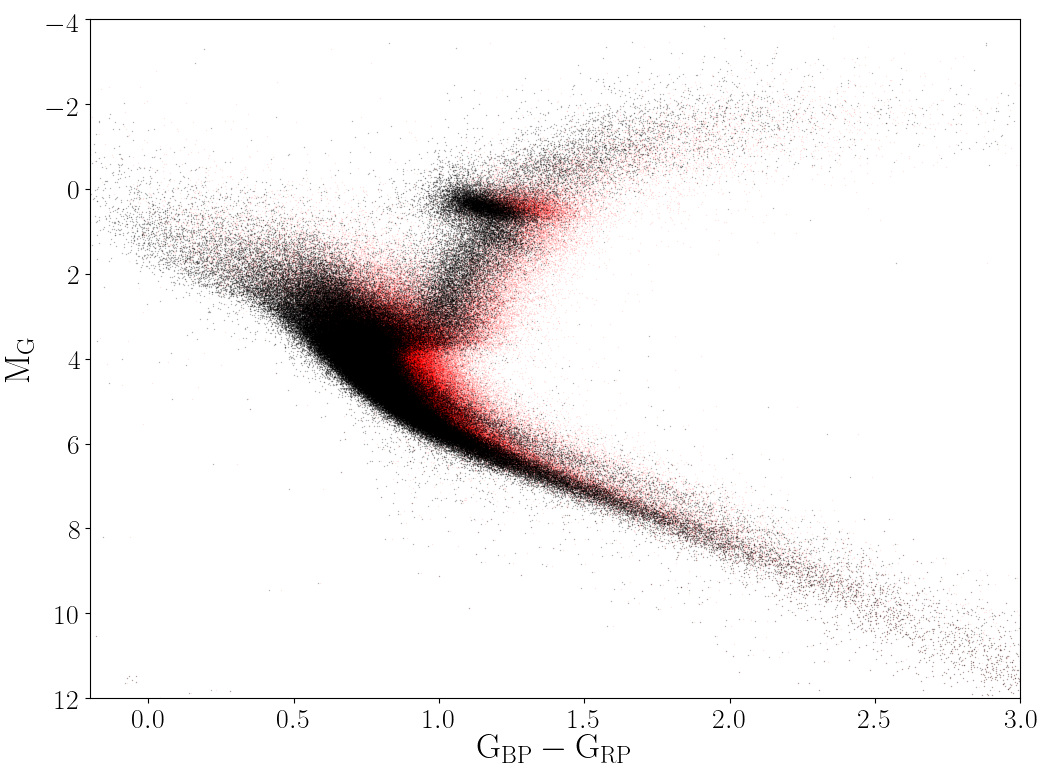

In [4]:
plt.figure(figsize=(12, 9), dpi=100)
plt.plot(df.phot_bp_mean_mag - df.phot_rp_mean_mag, df.abs_G, "r.", ms=2, alpha=.1, mec="none", zorder=0, rasterized=True)
plt.plot(df.bprp_dered, df.abs_G, "k.", ms=2, alpha=.3, mec="none", zorder=1)
plt.ylim(12, -4)
plt.xlim(-.2, 3)
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$");
plt.ylabel("$\mathrm{M_G}$");

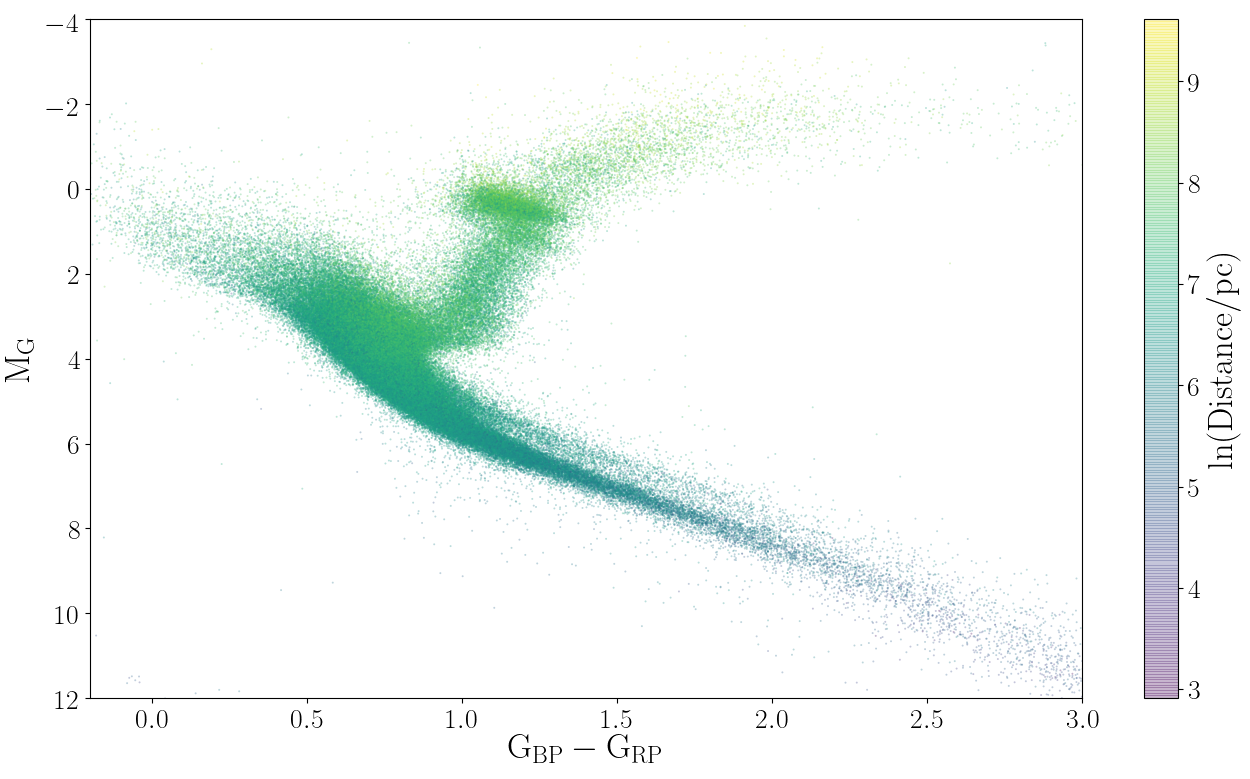

In [5]:
plt.figure(figsize=(16, 9), dpi=100)
plt.scatter(df.bprp_dered, df.abs_G, c=np.log(df.r_est), s=2, alpha=.3, edgecolor="none", zorder=1, rasterized=True)
plt.ylim(12, -4)
plt.xlim(-.2, 3)
plt.colorbar(label="$\ln(\mathrm{Distance/pc})$")
plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$");
plt.ylabel("$\mathrm{M_G}$");

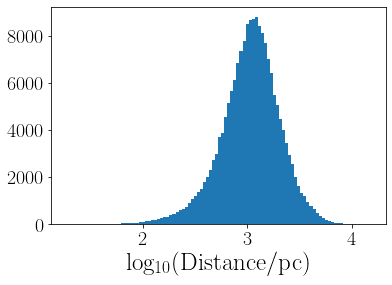

In [6]:
plt.hist(np.log10(df.r_est), 100);
plt.xlabel("$\mathrm{log_{10}(Distance/pc)}$");

# Look at the prior.

In [7]:
import starspot as ss

def mean_and_var(vx, vy, vz, lnD):
    V = np.stack((vx, vy, vz, lnD), axis=0)
    return np.mean(V, axis=1), np.cov(V)

lnD = np.log(1./df.parallax)
finite = np.isfinite(df.vx.values) & np.isfinite(df.vy.values) \
    & np.isfinite(df.vz.values) & np.isfinite(lnD)

nsigma = 3
mx = ss.sigma_clip(df.vx.values[finite], nsigma=nsigma)
my = ss.sigma_clip(df.vy.values[finite], nsigma=nsigma)
mz = ss.sigma_clip(df.vz.values[finite], nsigma=nsigma)
md = ss.sigma_clip(lnD[finite], nsigma=nsigma)
m = mx & my & mz & md

mu, cov = mean_and_var(df.vx.values[finite][m],
                       df.vy.values[finite][m],
                       df.vz.values[finite][m],
                       lnD[finite][m])

print(np.shape(cov))

(4, 4)


In [8]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse_mod(x, y, cov, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

#     cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [9]:
# cov = np.array([[cov[0, 0], cov[0, 1]], [cov[1, 0], cov[1, 1]]])

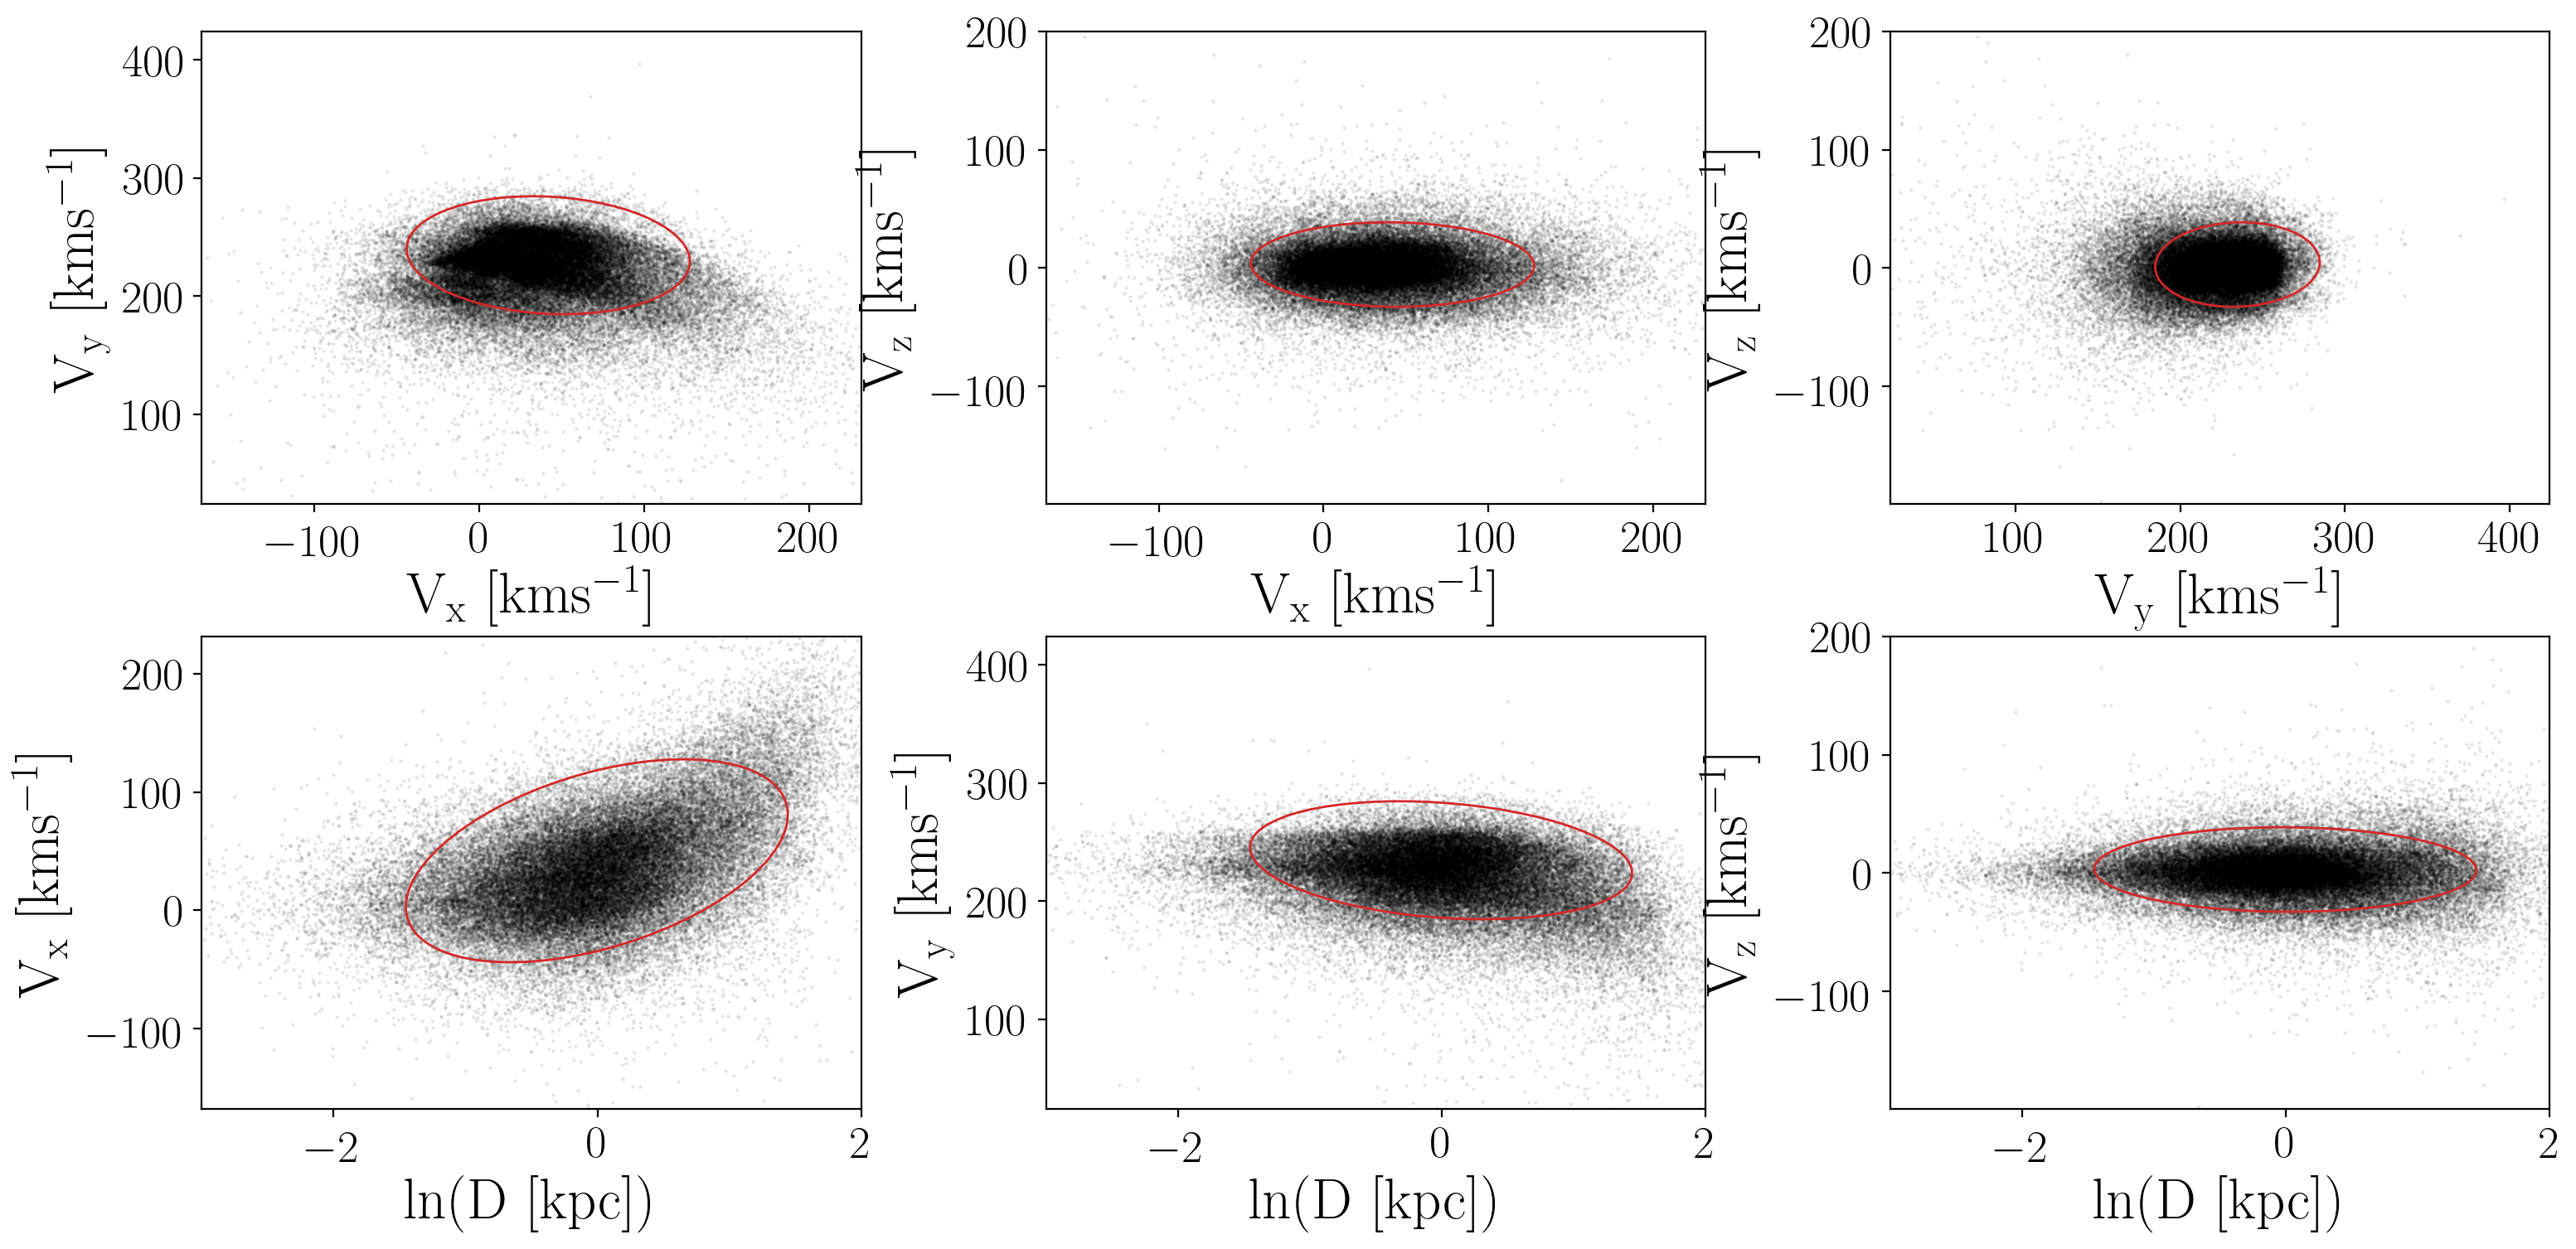

In [10]:
alpha, ms = .1, 1
color = "C3"

box = 200
m = np.isfinite(df.vx.values) & np.isfinite(df.vy.values) & np.isfinite(df.vz.values) & np.isfinite(lnD)
vx_c, vy_c, vz_c, lnD_c = df.vx.values[m], df.vy.values[m], df.vz.values[m], lnD[m]
medx, medy, medz = np.median(vx_c), np.median(vy_c), np.median(vz_c)
xlim, ylim, zlim, dlim = (medx-box, medx+box), (medy-box, medy+box), (medz-box, medz+box), (-3, 2)

fig = plt.figure(figsize=(16, 8), dpi=200)
ax0 = fig.add_subplot(231)
ax0.plot(vx_c, vy_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[0, 0], cov[0, 1]], [cov[1, 0], cov[1, 1]]])
confidence_ellipse_mod(vx_c, vy_c, _cov, ax0, n_std=2, edgecolor=color, zorder=1)
ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
ax0.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax0.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")

ax1 = fig.add_subplot(232)
ax1.plot(vx_c, vz_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[0, 0], cov[0, 2]], [cov[2, 0], cov[2, 2]]])
confidence_ellipse_mod(vx_c, vz_c, _cov, ax1, n_std=2, edgecolor=color, zorder=1)
ax1.set_xlim(xlim)
ax1.set_ylim(zlim)
ax1.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax1.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax2 = fig.add_subplot(233)
ax2.plot(vy_c, vz_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[1, 1], cov[1, 2]], [cov[2, 1], cov[2, 2]]])
confidence_ellipse_mod(vy_c, vz_c, _cov, ax2, n_std=2, edgecolor=color, zorder=1) 
ax2.set_xlim(ylim)
ax2.set_ylim(zlim)
ax2.set_xlabel("$\mathrm{V_y~[kms^{-1}]}$")
ax2.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax3 = fig.add_subplot(234)
ax3.plot(lnD_c, vx_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[3, 3], cov[3, 0]], [cov[0, 3], cov[0, 0]]])
confidence_ellipse_mod(lnD_c, vx_c, _cov, ax3, n_std=2, edgecolor=color, zorder=1)
ax3.set_ylabel("$\mathrm{V_x~[kms^{-1}]}$")
ax3.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
ax3.set_xlim(dlim)
ax3.set_ylim(xlim)

ax4 = fig.add_subplot(235)
ax4.plot(lnD_c, vy_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[3, 3], cov[3, 1]], [cov[1, 3], cov[1, 1]]])
confidence_ellipse_mod(lnD_c, vy_c, _cov, ax4, n_std=2, edgecolor=color, zorder=1)
ax4.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")
ax4.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
ax4.set_xlim(dlim)
ax4.set_ylim(ylim)

ax5 = fig.add_subplot(236)
ax5.plot(lnD_c, vz_c, "k.", alpha=alpha, ms=ms, rasterized=True, zorder=0)
_cov = np.array([[cov[3, 3], cov[3, 2]], [cov[2, 3], cov[2, 2]]])
confidence_ellipse_mod(lnD_c, vz_c, _cov, ax5, n_std=2, edgecolor=color, zorder=1)
ax5.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")
ax5.set_xlabel("$\mathrm{\ln(D~[kpc])}$")
ax5.set_xlim(dlim)
ax5.set_ylim(zlim)

plt.tight_layout()
plt.subplots_adjust(hspace=.28, wspace=.28)

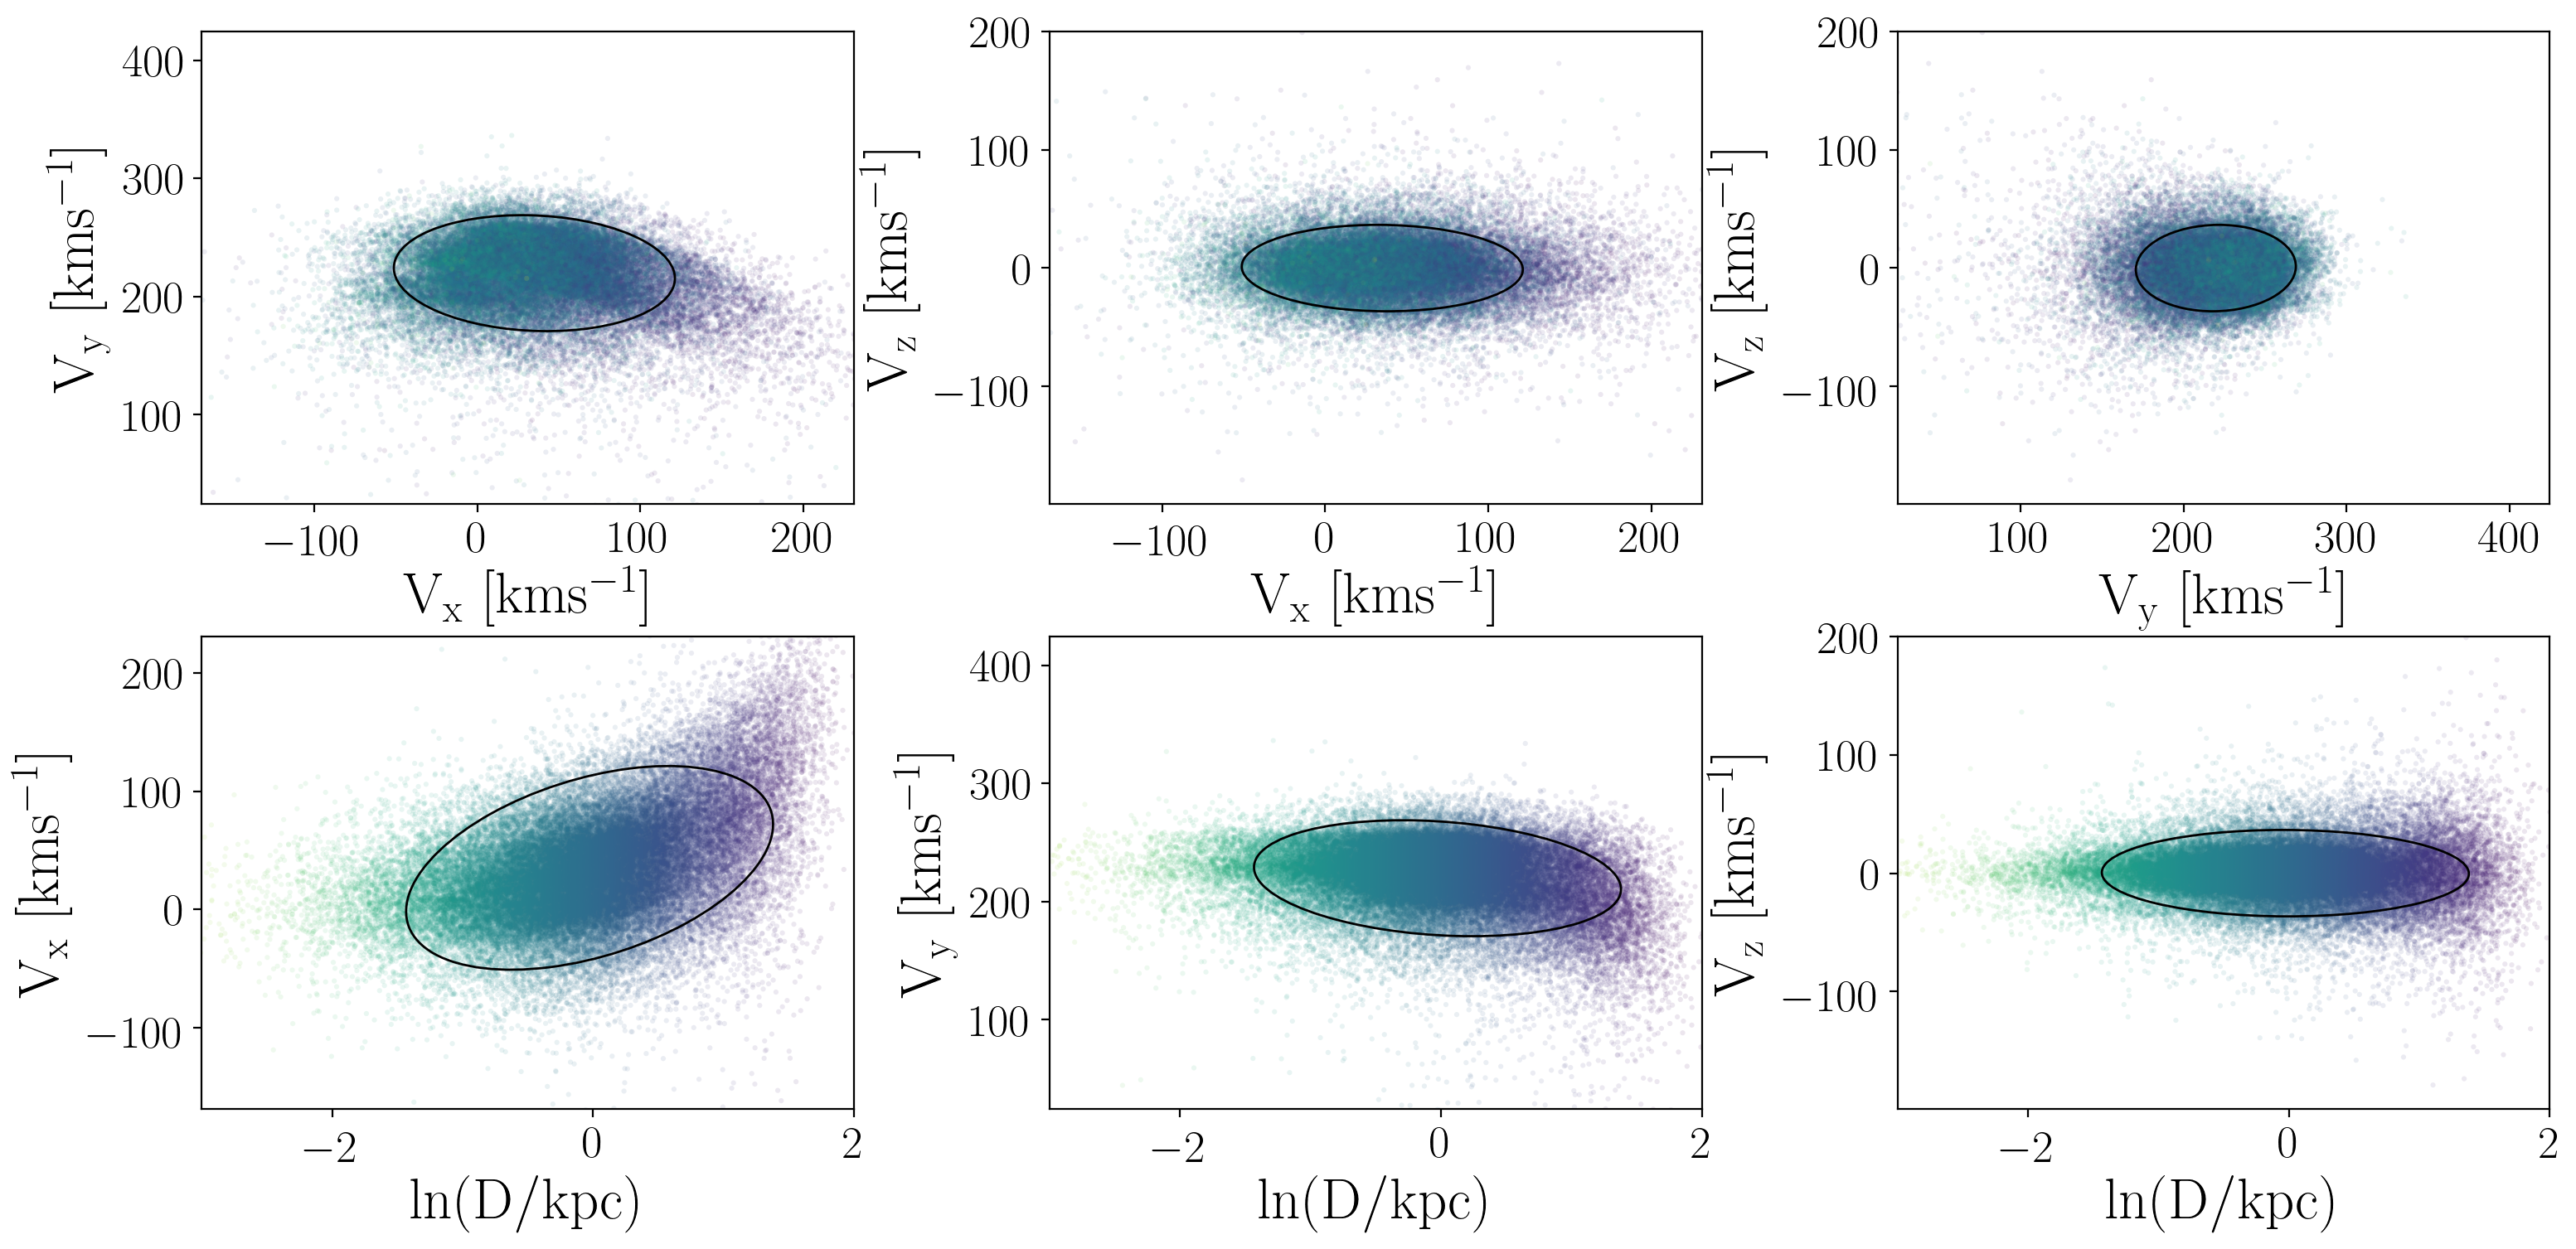

In [178]:
alpha, ms = .1, 1
color = "k"
cmap = "viridis_r"

fig = plt.figure(figsize=(16, 8), dpi=200)
ax0 = fig.add_subplot(231)
ax0.scatter(vx_c, vy_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[0, 0], cov[0, 1]], [cov[1, 0], cov[1, 1]]])
confidence_ellipse_mod(vx_c, vy_c, _cov, ax0, n_std=2, edgecolor=color, zorder=1)
ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
ax0.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax0.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")

ax1 = fig.add_subplot(232)
ax1.scatter(vx_c, vz_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[0, 0], cov[0, 2]], [cov[2, 0], cov[2, 2]]])
confidence_ellipse_mod(vx_c, vz_c, _cov, ax1, n_std=2, edgecolor=color, zorder=1)
ax1.set_xlim(xlim)
ax1.set_ylim(zlim)
ax1.set_xlabel("$\mathrm{V_x~[kms^{-1}]}$")
ax1.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax2 = fig.add_subplot(233)
ax2.scatter(vy_c, vz_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[1, 1], cov[1, 2]], [cov[2, 1], cov[2, 2]]])
confidence_ellipse_mod(vy_c, vz_c, _cov, ax2, n_std=2, edgecolor=color, zorder=1) 
ax2.set_xlim(ylim)
ax2.set_ylim(zlim)
ax2.set_xlabel("$\mathrm{V_y~[kms^{-1}]}$")
ax2.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")

ax3 = fig.add_subplot(234)
ax3.scatter(lnD_c, vx_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[3, 3], cov[3, 0]], [cov[0, 3], cov[0, 0]]])
confidence_ellipse_mod(lnD_c, vx_c, _cov, ax3, n_std=2, edgecolor=color, zorder=1)
ax3.set_ylabel("$\mathrm{V_x~[kms^{-1}]}$")
ax3.set_xlabel("$\mathrm{\ln(D/kpc)}$")
ax3.set_xlim(dlim)
ax3.set_ylim(xlim)

ax4 = fig.add_subplot(235)
ax4.scatter(lnD_c, vy_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[3, 3], cov[3, 1]], [cov[1, 3], cov[1, 1]]])
confidence_ellipse_mod(lnD_c, vy_c, _cov, ax4, n_std=2, edgecolor=color, zorder=1)
ax4.set_ylabel("$\mathrm{V_y~[kms^{-1}]}$")
ax4.set_xlabel("$\mathrm{\ln(D/kpc)}$")
ax4.set_xlim(dlim)
ax4.set_ylim(ylim)

ax5 = fig.add_subplot(236)
ax5.scatter(lnD_c, vz_c, c=lnD_c, s=5, alpha=alpha, edgecolor="none", rasterized=True, zorder=0, cmap=cmap)
_cov = np.array([[cov[3, 3], cov[3, 2]], [cov[2, 3], cov[2, 2]]])
confidence_ellipse_mod(lnD_c, vz_c, _cov, ax5, n_std=2, edgecolor=color, zorder=1)
ax5.set_ylabel("$\mathrm{V_z~[kms^{-1}]}$")
ax5.set_xlabel("$\mathrm{\ln(D/kpc)}$")
ax5.set_xlim(dlim)
ax5.set_ylim(zlim)

# plt.colorbar()
plt.tight_layout()
plt.subplots_adjust(hspace=.28, wspace=.3)

54553 122819


Text(0.5, 0, 'Distance [pc]')

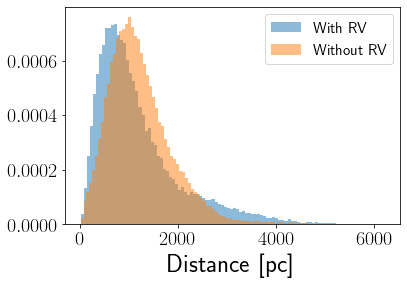

In [179]:
wrv = np.isfinite(df.rv.values) & (df.rv.values != 0)
print(len(df.r_est.values[wrv]), len(df.r_est.values[~wrv]))
plt.hist(df.r_est.values[wrv], 100, density=True, alpha=.5, label="With RV");
plt.hist(df.r_est.values[~wrv], 100, density=True, alpha=.5, label="Without RV");
plt.legend()
# plt.xlim(0, 10)
plt.xlabel("Distance [pc]")